In [10]:
#%% Import Moduels

## System Tools
import os
import sys
import numpy as np
## I/O Tools
import _pickle as pickle
## Data Process Tools
import pandas as pd
import datetime
## Graphs
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf as figpdf
import matplotlib.dates as matdates
## Statistical Tools
import statsmodels.api as sm
import scipy.stats as stats
## Database API
from fredapi import Fred
## API for WRDS
import wrds

# End of Section: Import Moduels
###############################################################################


#%% Setup Working Directory
## Windows System Path
FolderList = [xx+"\\Dropbox\\Research Projects\\02_FirmHete_AsymmetricInformation\\Data\\Micro_data\\codes\\" \
              for xx in ["D:\\", "E:\\","B:\\","/mnt/b/"]]
for Folder in FolderList:
    if os.path.exists(Folder):
        os.chdir(Folder)     

## Output Folder
OutputFolder = '../results/AbReturnCyclicality/'
if not os.path.exists(OutputFolder):
    os.makedirs(OutputFolder)
# End of Section: Setup Working Directory
###############################################################################
    

# End of Section: Setup Working Directory
###############################################################################


#%% Import Self-written Functions
CodeFolder      =   "../../../../../Code/PythonLib/"

sys.path.append(CodeFolder)

import Toolkit_TimeSeries as MyTS
import Toolkit_Graphics as MyGR
# End of Section: Import Self-written Functions
###############################################################################




# Time-series plot

## Load in the data

In [11]:
DataFolder      =   "..\\temp\\"
CalHist         =   pd.read_pickle(DataFolder+'SDC_AbRet_CalHist.p')

## Construct the aggregate time series data

In [27]:
# Select the accumulated abnormal returns of a given time window
Sample          =   CalHist.copy().set_index('Date')

VarList         =   []
for IF in ['I','F']:
    for NW in ['N','W']:
        for t in [-1,]:
            VarList.append(IF+'_AccAbRet_'+str(t)+'_1_'+NW)

Sample          =   Sample.loc[:, VarList]*100
Sample.sort_index(inplace=True)

# Add the aggregate price and quantity data
temp = pd.read_pickle('../../Macro_data/temp/AggDS_Dict_AggPQ.p')

# Add the recession indicator
Date    =   [['1980-1-1','1980-7-1'], ['1981-7-1','1982-11-1'], ['1990-7-1','1991-3-1'], ['2001-3-1','2001-11-1'], ['2007-12-1','2009-6-1']]

Sample = Sample.merge(temp['Detrend'][['Growth_GDP', 'GDP']], left_index=True, right_index=True, how='left')

## Time-series plot

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


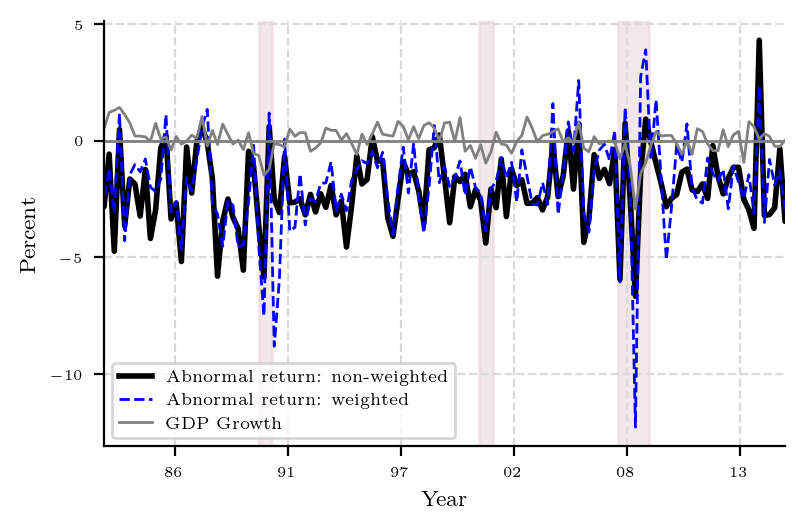

In [28]:
GraphFolder = OutputFolder

Fig = MyGR.Setup_Fig()
ax = Fig.add_subplot(1,1,1)
MyGR.Line(Width=2).Plot(Sample.index, Sample['F_AccAbRet_-1_1_N'], ax=ax, Label="Abnormal return: non-weighted")
MyGR.Line(Color="Blue", Style="dashed", Width=1).Plot(Sample.index, Sample['F_AccAbRet_-1_1_W'], ax=ax, Label="Abnormal return: weighted")
MyGR.Line(Color="Gray", Style="solid", Width=1).Plot(Sample.index, Sample['Growth_GDP'], ax=ax, Label="GDP Growth")
ax.set_xlim([datetime.date(1983,1,1),datetime.date(2015,12,31)])
ax.set_ylabel('Percent', fontsize=8) 
ax.set_xlabel('Year', fontsize=8)
ax.tick_params(axis='both', labelsize=5)
MyGR.NBER_RecessionBar(ax)
MyGR.Setup_Ax(ax, XDateFlag=True, XTickNbins=10)
plt.legend(loc='lower left', fontsize=6)

plt.tight_layout()

plt.savefig(GraphFolder+'AccAbRet_BusinessCycle.eps', format='eps', dpi=1000)

In [29]:
Sample 

,I_AccAbRet_-1_1_N,I_AccAbRet_-1_1_W,F_AccAbRet_-1_1_N,F_AccAbRet_-1_1_W,Growth_GDP,GDP
Date,,,,,,
1970-01-01,-1.468439,-1.116568,NaN,NaN,-1.519797,-3.524077
1970-04-01,-3.624261,-4.667988,NaN,NaN,-0.720074,-3.998625
1970-07-01,4.744363,2.967486,NaN,NaN,0.038925,-3.805440
1970-10-01,0.036758,-2.877378,NaN,NaN,-1.597087,-5.287046
1971-01-01,0.587433,2.687104,NaN,NaN,1.376797,-3.600292
...,...,...,...,...,...,...
2017-10-01,-5.226458,-0.787112,-2.725497,1.700341,0.611469,-4.859592
2018-01-01,-5.741706,-1.783128,-5.125522,-1.094996,0.402243,-4.667244
2018-04-01,-7.806915,-1.475034,-6.317839,-3.405149,0.069425,-4.756065


In [33]:
non_nan_index = Sample.dropna().index
TempIndex = non_nan_index[(non_nan_index>=datetime.datetime(1983,1,1)) & (non_nan_index<=datetime.datetime(2015,12,31))] 

TempVarList = ['F_AccAbRet_-1_1_W', 'F_AccAbRet_-1_1_N']

TempTab = pd.concat([pd.Series(stats.pearsonr(Sample.loc[TempIndex, vv], Sample.loc[TempIndex, 'Growth_GDP']), index=['Corr', 'p-value']) for vv in TempVarList], axis=1, keys=TempVarList)

TempTab.to_latex(GraphFolder+'Corr_w_GDPGrowth.tex', float_format="%.3g", escape=True)

TempTab 

,F_AccAbRet_-1_1_W,F_AccAbRet_-1_1_N
Corr,0.240662,0.179931
p-value,0.005441,0.038973


# Summary statistics: recession vs. non-recession

## Load in the data

In [45]:
DataFolder          =   "..\\temp\\"
SDC_AbRet_Wide      =   pd.read_pickle(DataFolder+"SDC_AbRet_Wide.p")
SDC_IssuanceInfo    =   pd.read_pickle(DataFolder+"SDC_IssuanceInfo.p") 

In [49]:
VarList_AbRet = ['F_AccAbRet_-1_1', 'I_AccAbRet_-1_1']

temp = SDC_AbRet_Wide.loc[:, ['IssueID']+VarList_AbRet]
temp[VarList_AbRet] = temp[VarList_AbRet]*100

In [50]:
Sample = SDC_IssuanceInfo.merge(temp, how='left', left_on='IssueID', right_on='IssueID')

In [51]:
# Add the recession indicator
NBER_recessions = [
    (datetime.date(1980, 1, 1), datetime.date(1980, 7, 1)),
    (datetime.date(1981, 7, 1), datetime.date(1982, 11, 1)),
    (datetime.date(1990, 7, 1), datetime.date(1991, 3, 1)),
    (datetime.date(2001, 3, 1), datetime.date(2001, 11, 1)),
    (datetime.date(2007, 12, 1), datetime.date(2009, 6, 1)),
    # Add more recession periods as needed
]

def is_during_nber_recession(date):
    """
    Check if a given date falls within any NBER recession period.
'
    Parameters:
    date (datetime.date): The date to check.

    Returns:
    bool: True if the date is during an NBER recession, False otherwise.
    """
    for start, end in NBER_recessions:
        if start <= date <= end:
            return True
    return False

Sample['FilingDate_RecFlag'] = Sample['FilingDate'].apply(lambda x: is_during_nber_recession(x)*1 if pd.isna(x)==False else np.nan)
Sample['IssueDate_RecFlag'] = Sample['IssueDate'].apply(lambda x: is_during_nber_recession(x)*1 if pd.isna(x)==False else np.nan)

In [60]:
# Measure the price drop differently for firms with different shelf-issuance type 
TempInd = Sample['ShelfIssueFlag']==1

Sample['EventDate'] = Sample['FilingDate']
Sample.loc[TempInd, 'EventDate'] = Sample.loc[TempInd, 'IssueDate']

Sample['AccAbRet'] = Sample['F_AccAbRet_-1_1']
Sample.loc[TempInd, 'AccAbRet'] = Sample.loc[TempInd, 'I_AccAbRet_-1_1']

Sample['EventDate_Quarter'] = Sample['FilingDate_Quarter']
Sample.loc[TempInd, 'EventDate_Quarter'] = Sample.loc[TempInd, 'IssueDate_Quarter']

Sample['EventDate_RecFlag'] = Sample['EventDate'].apply(lambda x: is_during_nber_recession(x)*1 if pd.isna(x)==False else np.nan)

In [103]:
TempIndex = (Sample['EventDate']>=datetime.date(1983,1,1)) & (Sample['EventDate']<=datetime.date(2015,12,31))
TempTab = Sample.loc[TempIndex, :].groupby('EventDate_RecFlag')['AccAbRet'].describe()

TempTab.to_latex(GraphFolder+'AccAbRet_RecessionVsNonRecession.tex', float_format="%.3g", escape=True)

TempTab 

,count,mean,std,min,25%,50%,75%,max
EventDate_RecFlag,,,,,,,,
0.0,5384.0,-2.569519,8.448932,-112.353636,-5.819877,-2.134031,1.476335,64.243497
1.0,264.0,-4.434145,8.917520,-46.963136,-8.635520,-3.898657,0.374833,26.100980


In [104]:
# T-Test of the Abnormal Returns in recessions and non-recessions
group1 = Sample.loc[TempIndex & (Sample['EventDate_RecFlag']==1), 'AccAbRet']
group2 = Sample.loc[TempIndex & (Sample['EventDate_RecFlag']==0), 'AccAbRet']

# Perform the two-sample t-test
t_stat, p_value = stats.ttest_ind(group1.dropna(), group2.dropna())
print(f"T-statistic: {t_stat}, P-value: {p_value}")

T-statistic: -3.4917805227730225, P-value: 0.00048348508403347204


In [92]:
def TempFun_WM(DS,VarList,WeightVar):
    Temp_Num        =   DS[VarList].multiply(DS[WeightVar],axis=0).sum(axis=0)
    Temp_DeNum      =   ( ~pd.isna(DS[VarList]) ).multiply(DS[WeightVar],axis=0).sum(axis=0)
    WM              =   Temp_Num.divide(Temp_DeNum,axis=0)
    WM.name         =   'WMean'
    
    return WM

DataForPlot = pd.concat([Sample.groupby('EventDate_Quarter')['AccAbRet'].mean().sort_index().rename('AccAbRet_Avg'), \
                         Sample.groupby('EventDate_Quarter').apply(TempFun_WM, ['AccAbRet'], 'ProceedsAmount', include_groups=False).sort_index()['AccAbRet'].rename('AccAbRet_WAvg')], \
                        axis=1).sort_index()

In [94]:
# Add the aggregate price and quantity data
temp = pd.read_pickle('../../Macro_data/temp/AggDS_Dict_AggPQ.p')

DataForPlot = DataForPlot.merge(temp['Detrend'][['Growth_GDP', 'GDP']], left_index=True, right_index=True, how='left')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


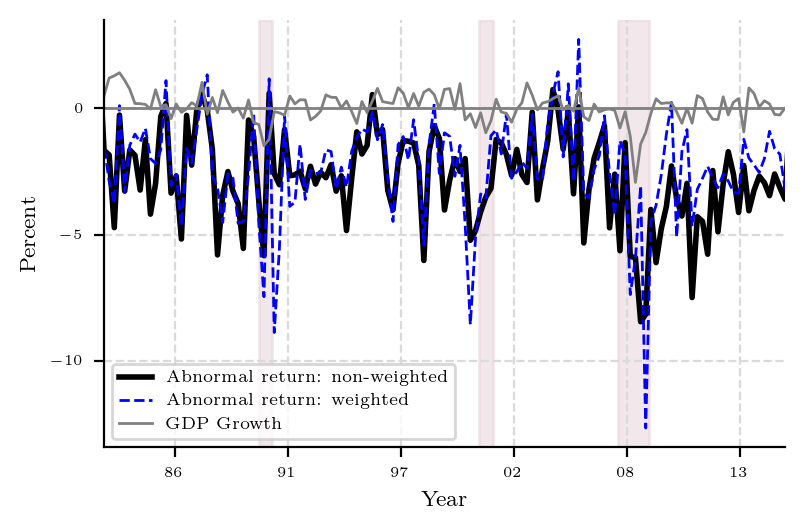

In [99]:
GraphFolder = OutputFolder

Fig = MyGR.Setup_Fig()
ax = Fig.add_subplot(1,1,1)
MyGR.Line(Width=2).Plot(DataForPlot.index, DataForPlot['AccAbRet_Avg'], ax=ax, Label="Abnormal return: non-weighted")
MyGR.Line(Color="Blue", Style="dashed", Width=1).Plot(DataForPlot.index, DataForPlot['AccAbRet_WAvg'], ax=ax, Label="Abnormal return: weighted")
MyGR.Line(Color="Gray", Style="solid", Width=1).Plot(DataForPlot.index, DataForPlot['Growth_GDP'], ax=ax, Label="GDP Growth")
ax.set_xlim([datetime.date(1983,1,1),datetime.date(2015,12,31)])
ax.set_ylabel('Percent', fontsize=8) 
ax.set_xlabel('Year', fontsize=8)
ax.tick_params(axis='both', labelsize=5)
MyGR.NBER_RecessionBar(ax)
MyGR.Setup_Ax(ax, XDateFlag=True, XTickNbins=10)
plt.legend(loc='lower left', fontsize=6)

plt.tight_layout()

plt.savefig(GraphFolder+'AccAbRet_BusinessCycle.eps', format='eps', dpi=1000)

In [98]:
non_nan_index = DataForPlot.dropna().index
TempIndex = non_nan_index[(non_nan_index>=datetime.datetime(1983,1,1)) & (non_nan_index<=datetime.datetime(2015,12,31))] 

TempVarList = ['AccAbRet_Avg', 'AccAbRet_WAvg']

TempTab = pd.concat([pd.Series(stats.pearsonr(DataForPlot.loc[TempIndex, vv], DataForPlot.loc[TempIndex, 'Growth_GDP']), index=['Corr', 'p-value']) for vv in TempVarList], axis=1, keys=TempVarList)

TempTab.to_latex(GraphFolder+'Corr_w_GDPGrowth.tex', float_format="%.3g", escape=True)

TempTab 

,AccAbRet_Avg,AccAbRet_WAvg
Corr,0.355949,0.355401
p-value,0.000028,0.000029


# Run the regression to control the selection of issuance

In [20]:
### One Single Simple Regression
def TempFun_SingleReg(DS,YVar,XVarList,WeightVar='',ClusterIDVar=''):
    if WeightVar=='':
        if ClusterIDVar=='':
            TempReg     =   sm.OLS(DS[YVar],sm.add_constant(DS[XVarList]), \
                               missing='drop').fit()
        else:
            TempReg     =   sm.OLS(DS[YVar],sm.add_constant(DS[XVarList]), \
                                   missing='drop'). \
                                   fit(cov_type='cluster',cov_kwds={'groups': DS[ClusterIDVar]})
    else:
        if ClusterIDVar=='':
            TempReg     =   sm.OLS(DS[YVar],sm.add_constant(DS[XVarList]), \
                               weights=DS[WeightVar], \
                               missing='drop').fit()
        else:
            TempReg     =   sm.OLS(DS[YVar],sm.add_constant(DS[XVarList]), \
                                   weights=DS[WeightVar], \
                                   missing='drop'). \
                                   fit(cov_type='cluster',cov_kwds={'groups': DS[ClusterIDVar]})
    TempTable   =   pd.concat([pd.DataFrame(TempReg.params,columns=[YVar]), \
                               pd.DataFrame(TempReg.tvalues,columns=[YVar]), \
                               pd.DataFrame(TempReg.bse,columns=[YVar]), \
                               pd.DataFrame(TempReg.pvalues,columns=[YVar])], \
                              axis=0,keys=['Coef','Tstat','Se','Pvalue']) \
                    .swaplevel(i=0,j=1,axis=0)
    TempTable.loc[('RegInfo','Obs'),YVar]    =   TempReg.nobs
    TempTable.loc[('RegInfo','R2'),YVar]     =   TempReg.rsquared
    
    TempTable.sort_index(inplace=True)
    
    return TempTable,TempReg


In [18]:
### A Single Regression with a Given Regression Setup (with Monetary Shocks)
def TempFun_GroupUnitReg_Ms(DS,GroupVar,DateLimit,EventDict, \
                            RetVar,MsVar, \
                            XList_Macro,XList_Firm,XList_IndRet,XList_FirmFix, \
                            MacroSuffix='',FirmSuffix='',WeightVar='', \
                            TimeFixEffect='No',Cluster='No'):
    
    ## Preliminary
    DateType        =   EventDict['Suffix']
    DateVar         =   EventDict['DateVar']
    
    ## Assemble the Variables
    # Y-Variables
    YVar            =   DateType+'_'+RetVar
    # X-Variables
    if MacroSuffix=='' and MsVar!='':
        XVarList_Macro  =   [DateType+'_'+MsVar+'_'+x for x in XList_Macro]
    else:
        XVarList_Macro  =   [DateType+'_'+MacroSuffix+'_'+x for x in XList_Macro]
    
    if FirmSuffix=='' and MsVar!='':
        XVarList_Firm   =   [DateType+'_'+MsVar+'_'+x for x in XList_Firm]
    else:
        XVarList_Firm   =   [DateType+'_'+FirmSuffix+'_'+x for x in XList_Firm]

    XVarList_IndRet =   [DateType+'_'+x for x in XList_IndRet]
    XVarList_FirmFix=   XList_FirmFix
    
    if MsVar=='':
        MsType          =   'NoMs'
        XVarList        =   XVarList_Macro+XVarList_Firm+XVarList_IndRet+XVarList_FirmFix
        XLabelList      =   XList_Macro+XList_Firm+XList_IndRet+XVarList_FirmFix
    else:
        MsType          =   MsVar
        XVarList        =   [DateType+'_'+MsVar]+ \
                            XVarList_Macro+XVarList_Firm+XVarList_IndRet+XVarList_FirmFix
        XLabelList      =   ['Ms']+ \
                            XList_Macro+XList_Firm+XList_IndRet+XVarList_FirmFix
    
    ## Assemble the Data
    # Restrict to the given Sample Period
    TempInd         =   ( DS[DateVar]>=DateLimit[0] ) & ( DS[DateVar]<=DateLimit[1] )
    EffectiveDS     =   DS.loc[TempInd,:].copy()
    
    # Generate the Clustering ID
    if Cluster=='Year':
        EffectiveDS['ClusterID']    =   EffectiveDS[DateVar+'_Year'].map(lambda x: x.year)
    elif Cluster=='Quarter':
        EffectiveDS['ClusterID']    =   EffectiveDS[DateVar+'_Quarter'].map(lambda x: x.year*100+x.month)
    else:
        EffectiveDS['ClusterID']    =   0
    # Generate the Dummy Variables for Time-Fix Effects
    TimeFixEffectVarList    =   []
    if TimeFixEffect=='Year' and TimeFixEffect!='No':
        TimeList        =   EffectiveDS[DateVar+'_Year'].unique().tolist()
        
        if len(TimeList)>=2:
            
            for ii in range(1,len(TimeList)):
                TimeFixEffectVar        =   'Flag_'+str(TimeList[ii].year)
                TimeFixEffectVarList    =   TimeFixEffectVarList+[TimeFixEffectVar]
                EffectiveDS[TimeFixEffectVar]       =   0
                EffectiveDS.loc[EffectiveDS[DateVar+'_Year']==TimeList[ii], \
                                TimeFixEffectVar]   =   1
     
    elif TimeFixEffect=='Quarter' and TimeFixEffect!='No':
        TimeList        =   EffectiveDS[DateVar+'_Quarter'].unique().tolist()
        if len(TimeList)>=2:
            for ii in range(1,len(TimeList)):
                TimeFixEffectVar        =   'Flag_'+str(TimeList[ii].year)+ \
                                            '_'+str(TimeList[ii].month)
                TimeFixEffectVarList    =   TimeFixEffectVarList+[TimeFixEffectVar]
                EffectiveDS[TimeFixEffectVar]       =   0
                EffectiveDS.loc[EffectiveDS[DateVar+'_Quarter']==TimeList[ii], \
                                TimeFixEffectVar]   =   1
    
    
    XVarList    =   XVarList+TimeFixEffectVarList
    XLabelList  =   XLabelList+TimeFixEffectVarList
    # Generate the Group Variable for the 'Pooled' Regression
    if GroupVar=='Pooled':
        EffectiveDS[GroupVar]   =   0
    # Drop the missing Values
    RegVarList      =   list(set([YVar]+XVarList+[GroupVar]+['ClusterID']))
    EffectiveDS     =   EffectiveDS[RegVarList].dropna().reset_index(drop=True)
    # Extract the Unique Value List of the Group Variables
    GroupValueList  =   EffectiveDS[GroupVar].unique().tolist()
    
    
    ## Computation
    InitiateFlag    =   True
    for GroupValue in GroupValueList:
        # Regression Sample
        RegDS           =   EffectiveDS[EffectiveDS[GroupVar]==GroupValue].reset_index(drop=True)
        
        # Check whether the XVar only has one value
        RegXVarList     =   []
        RegXLabelList   =   []
        for ii in range(len(XVarList)):
            TempXVarUniqueList  =   RegDS[XVarList[ii]].unique().tolist()
            if len(TempXVarUniqueList)>1:
                RegXVarList     =   RegXVarList+[XVarList[ii]]
                RegXLabelList   =   RegXLabelList+[XLabelList[ii]]
                # Normalization: demean the continuous control variables
                if len(TempXVarUniqueList)>2:
                    RegDS[XVarList[ii]]     =   ( RegDS[XVarList[ii]]- \
                                                  RegDS[XVarList[ii]].mean() )/1
        # Check whether there is only one Cluster Group 
        if len(RegDS['ClusterID'].unique().tolist())<=1:
            ClusterIDVar    =   ''
        else:
            ClusterIDVar    =   'ClusterID'
        # OLS (WLS)
        if RegDS.shape[0]>10:
            RegTable,RegInfo    =   TempFun_SingleReg(RegDS,YVar,RegXVarList,WeightVar,ClusterIDVar=ClusterIDVar)
            ColTuple            =   (DateType,RetVar,MsType, \
                                     str(DateLimit[0].year)+'-'+str(DateLimit[1].year), \
                                     GroupVar,GroupValue)
            RegTable.rename(columns={YVar: ColTuple},inplace=True)
            RegTable.columns    =   pd.MultiIndex.from_tuples(RegTable.columns.tolist())
            RegTable.rename(index={RegXVarList[i]: RegXLabelList[i] for i in range(len(RegXVarList))}, \
                                   level=0,inplace=True)
        else:
            RegTable    =   pd.DataFrame()
        # Collect the Result
        if InitiateFlag and (not RegTable.empty):
            RegResult   =   RegTable
            InitiateFlag=   False
        elif (not RegTable.empty):
            RegResult   =   RegResult.merge(right=RegTable,how='outer', \
                                            left_index=True,right_index=True)
    
    ## If there is no result to return, just return an empty dataframe       
    if InitiateFlag:
        RegResult   =   pd.DataFrame()
    
    return RegResult


## Load in the data

In [14]:
DataFolder      =   '..\\temp\\'
DS              =   pd.read_pickle(DataFolder+"RegSample.p")

<Axes: xlabel='FilingDate_Quarter'>

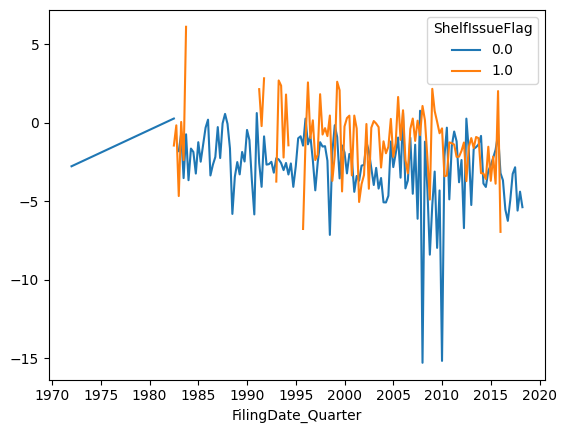

In [41]:
DS.groupby(['ShelfIssueFlag', 'FilingDate_Quarter'])['F_AccAbRet_-1_1'].mean().unstack(level='ShelfIssueFlag').plot()

<Axes: xlabel='IssueDate_Quarter'>

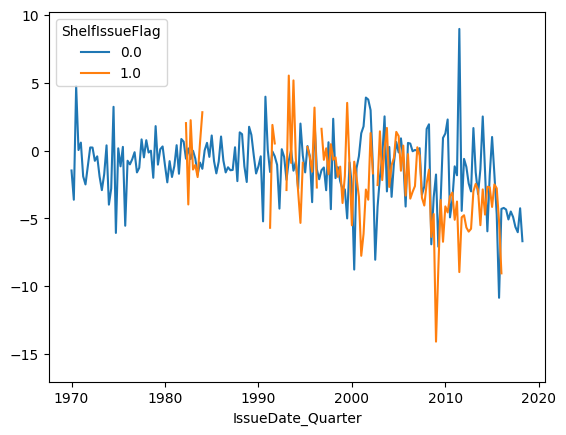

In [44]:
DS.groupby(['ShelfIssueFlag', 'IssueDate_Quarter'])['I_AccAbRet_-1_1'].mean().unstack(level='ShelfIssueFlag').plot()

In [36]:
tt = DS.columns.to_series().reset_index(drop=True)

In [34]:
GroupVar = 'Pooled'
DateLimit = [datetime.date(1983,1,1),datetime.date(2007,6,1)]
RetVar  = 'AccAbRet_-1_1'
EventDict = {'Suffix': 'F', 'DateVar': 'FilingDate'}
MsVar = '90d_MsRR'
MacroVarList    =   ['GdpGrowth','Inflation','UnemploymentRate','FedFundsRate','SpRet_Sum','SpRet_Std']
IndRetVarList   =   ['AbRetRunup','AbRetStd']
FirmVarList     =   ['Leverage','OfferedPrimarySharesDivByCommonShares_Outstanding', \
                     'Diff_LogSales_LowQuant','Diff_LogSales_UppQuant', \
                     'Lag_Asset_LowQuant','Lag_Asset_UppQuant', \
                    #  'Equity_M2B_LowQuant','Equity_M2B_UppQuant'
                     ]
FirmFixVarList  =   ['FF5_1','FF5_2','FF5_3','FF5_4', \
                     'PrimarySecondaryFlag','OnlySecondaryFlag', \
                     'ShelfIssueFlag']

RegDesignList   =   [{'MsFlag': False,'Macro': [], 'IndRet': IndRetVarList, 'Firm': FirmVarList,'FirmFix': FirmFixVarList}, \
                     {'MsFlag': True,'Macro': [], 'IndRet': [], 'Firm': [],'FirmFix': []}, \
                     {'MsFlag': True, 'Macro': MacroVarList,'IndRet': [], 'Firm': [],'FirmFix': []}, \
                     {'MsFlag': True, 'Macro': MacroVarList,'IndRet': IndRetVarList,'Firm': FirmVarList,'FirmFix': FirmFixVarList}
                    ]

RegDesign = RegDesignList[3]


TempResult  =   TempFun_GroupUnitReg_Ms(DS,GroupVar,DateLimit,EventDict, \
                                                            RetVar,MsVar, \
                                                            RegDesign['Macro'], \
                                                            RegDesign['Firm'], \
                                                            RegDesign['IndRet'], \
                                                            RegDesign['FirmFix'],\
                                                            MacroSuffix='', \
                                                            FirmSuffix='', \
                                                            TimeFixEffect='Year',Cluster='Year')

# DS,GroupVar,DateLimit,EventDict, \
#                             RetVar,MsVar, \
#                             XList_Macro,XList_Firm,XList_IndRet,XList_FirmFix, \
#                             MacroSuffix='',FirmSuffix='',WeightVar='', \
#                             TimeFixEffect='No',Cluster='No'

In [35]:
TempResult

F
                      AccAbRet_-1_1
                           90d_MsRR
                          1983-2007
                             Pooled
                                  0
FF5_1          Coef   -3.481150e-01
               Pvalue  3.239370e-01
               Se      3.529147e-01
               Tstat  -9.863998e-01
FF5_2          Coef   -2.110391e-03
..                              ...
ShelfIssueFlag Tstat   5.134332e+00
const          Coef   -2.401892e+00
               Pvalue  1.611199e-21
               Se      2.521010e-01
               Tstat  -9.527498e+00

[174 rows x 1 columns]

In [ ]:
TimeFixEffect='No',Cluster='No'

In [17]:
TempResult

F
                                                        AccAbRet_-1_1
                                                         90d_MsWideHF
                                                            1983-2007
                                                               Pooled
                                                                    0
FF5_1                                             Coef      -0.221466
                                                  Tstat     -0.501077
FF5_2                                             Coef       0.072638
                                                  Tstat      0.162984
FF5_3                                             Coef      -0.249654
                                                  Tstat     -0.583938
FF5_4                                             Coef      -0.623311
                                                  Tstat     -1.343265
Ms                                                Coef      -1.400406
                                                  Tstat     -1.170078
Diff_LogSales_LowQuant                            Coef       0.358602
                                                  Tstat      0.949408
Diff_LogSales_UppQuant                            Coef       0.200055
                                                  Tstat      0.719457
Equity_M2B_LowQuant                               Coef      -0.490944
                                                  Tstat     -0.848960
Equity_M2B_UppQuant                               Coef       0.642831
                                                  Tstat      2.327506
FedFundsRate                                      Coef       0.174658
                                                  Tstat      1.821106
GdpGrowth                                         Coef       0.138978
                                                  Tstat      2.195022
Inflation                                         Coef       0.192631
                                                  Tstat      0.861631
Lag_Asset_LowQuant                                Coef       0.695088
                                                  Tstat      1.036945
Lag_Asset_UppQuant                                Coef       0.636885
                                                  Tstat      1.940919
Leverage                                          Coef      -0.182711
                                                  Tstat     -0.296118
OfferedPrimarySharesDivByCommonShares_Outstanding Coef       0.026804
                                                  Tstat      2.970340
SpRet_Std                                         Coef      -0.134565
                                                  Tstat     -0.294190
SpRet_Sum                                         Coef       0.005204
                                                  Tstat      0.259062
UnemploymentRate                                  Coef       0.034980
                                                  Tstat      0.195426
AbRetRunup                                        Coef       0.009148
                                                  Tstat      2.582616
AbRetStd                                          Coef      -0.090012
                                                  Tstat     -1.552074
OnlySecondaryFlag                                 Coef      -0.634157
                                                  Tstat     -1.550720
PrimarySecondaryFlag                              Coef      -0.601601
                                                  Tstat     -1.971014
RegInfo                                           Obs     2795.000000
                                                  R2         0.024295
ShelfIssueFlag                                    Coef       1.435070
                                                  Tstat      3.991510
const                                             Coef      -4.394793
                                                  Tstat     -2.553030

In [ ]:
a

In [ ]:
## Preliminary
DateType        =   EventDict['Suffix']
DateVar         =   EventDict['DateVar']

## Assemble the Variables
# Y-Variables
YVar            =   DateType+'_'+RetVar
# X-Variables
if MacroSuffix=='' and MsVar!='':
    XVarList_Macro  =   [DateType+'_'+MsVar+'_'+x for x in XList_Macro]
else:
    XVarList_Macro  =   [DateType+'_'+MacroSuffix+'_'+x for x in XList_Macro]

if FirmSuffix=='' and MsVar!='':
    XVarList_Firm   =   [DateType+'_'+MsVar+'_'+x for x in XList_Firm]
else:
    XVarList_Firm   =   [DateType+'_'+FirmSuffix+'_'+x for x in XList_Firm]

XVarList_IndRet =   [DateType+'_'+x for x in XList_IndRet]
XVarList_FirmFix=   XList_FirmFix

if MsVar=='':
    MsType          =   'NoMs'
    XVarList        =   XVarList_Macro+XVarList_Firm+XVarList_IndRet+XVarList_FirmFix
    XLabelList      =   XList_Macro+XList_Firm+XList_IndRet+XVarList_FirmFix
else:
    MsType          =   MsVar
    XVarList        =   [DateType+'_'+MsVar]+ \
                        XVarList_Macro+XVarList_Firm+XVarList_IndRet+XVarList_FirmFix
    XLabelList      =   ['Ms']+ \
                        XList_Macro+XList_Firm+XList_IndRet+XVarList_FirmFix

## Assemble the Data
TempInd         =   ( DS[DateVar]>=DateLimit[0] ) & ( DS[DateVar]<=DateLimit[1] )
EffectiveDS     =   DS.loc[TempInd,:].copy()    
if GroupVar=='Pooled':
    EffectiveDS[GroupVar]   =   0
RegVarList      =   list(set([YVar]+XVarList+[GroupVar]))
EffectiveDS     =   EffectiveDS[RegVarList].dropna().reset_index(drop=True)
GroupValueList  =   EffectiveDS[GroupVar].unique().tolist()
